In [1]:
# Install libraries
%%capture
!pip install tensorflow-probability
!pip install imageio

In [22]:
# Import General Utilities
import numpy as np
import os
import random
from tqdm.notebook import tqdm, trange
import time
import datetime

#Import tensorflow and its requirements
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow.keras.datasets as tfds
import tensorflow.experimental.numpy as tnp
from tensorflow.data.experimental import cardinality as dlen
from tensorflow.keras import Model, Input
from tensorflow.keras import layers
AUTOTUNE = tf.data.AUTOTUNE
tnp.experimental_enable_numpy_behavior()

# Import plotting tools and image converters
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL
import imageio
from IPython import display
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA

# Import file path variable handling
from pathlib import Path
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile

# Constants
batch_size = 20
buffer_size = 64
epochs = 400
img_height = 256
img_width = 256
num_examples_to_generate = 8

print(tf.__version__)

2.7.0-dev20210803


In [3]:
# Download OASIS Dataset from the provided link

def download_and_unzip(url, extract_to='.'): # Credit to Antoine Hebert
    http_response = urlopen(url)
    zipfile = ZipFile(BytesIO(http_response.read()))
    zipfile.extractall(path=extract_to)
    http_response.close()

root_dir = '/root/.keras/datasets'
data_dir = Path(root_dir) / 'keras_png_slices_data'

if len(os.listdir(data_dir)) != 6:
    _URL = "https://cloudstor.aarnet.edu.au/plus/s/tByzSZzvvVh0hZA/download"
    download_and_unzip(_URL, extract_to=root_dir)
    #data_dir = tf.keras.utils.get_file('oasis3', origin=_URL, cache_subdir=root_dir, extract=True)

print(f"Data Directory is {data_dir}")
print(f"Contents: \n\r {os.listdir(data_dir)}")

# Folder Directory Paths
train_dir = data_dir / 'keras_png_slices_train'
train_ans_dir = data_dir / 'keras_png_slices_seg_train'
test_dir = data_dir / 'keras_png_slices_test'
test_ans_dir = data_dir / 'keras_png_slices_seg_test'
val_dir = data_dir / 'keras_png_slices_validate'
val_ans_dir = data_dir / 'keras_png_slices_seg_validate'

Data Directory is \root\.keras\datasets\keras_png_slices_data
Contents: 
 ['keras_png_slices_seg_test', 'keras_png_slices_seg_train', 'keras_png_slices_seg_validate', 'keras_png_slices_test', 'keras_png_slices_train', 'keras_png_slices_validate']


In [4]:
#def count_files(dat_path):
    #return len(list(dat_path.glob('*.*')))

train_ds_list = tf.data.Dataset.list_files(str(train_dir/'*.*'), shuffle=True)
test_ds_list = tf.data.Dataset.list_files(str(test_dir/'*.*'), shuffle=True)
val_ds_list = tf.data.Dataset.list_files(str(val_dir/'*.*'), shuffle=False)

train_ds = train_ds_list.take(dlen(train_ds_list))
test_ds = test_ds_list.take(dlen(test_ds_list))
val_ds = val_ds_list.take(dlen(val_ds_list))

print(f"Train Set is {dlen(train_ds_list)} images, Test Set is {dlen(test_ds_list)} images and Validation Set is {dlen(val_ds_list)} images.")

Train Set is 9664 images, Test Set is 544 images and Validation Set is 1120 images.


In [5]:
def decode_img(img):
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_png(img, channels=1)
    tfimg = tf.image.resize(img, [img_height, img_width])
    tfimg = (tfimg / 255.0) - 0.5 # Normalise data
    # Resize the image to the desired size
    return tfimg

def process_path(file_path):
    #label = get_label(file_path)
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img

train_ds_raw = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds_raw = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds_raw = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [6]:
def configure_for_performance(ds, batches):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=buffer_size)
    ds = ds.batch(batches)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = configure_for_performance(train_ds_raw, batch_size)
test_ds = configure_for_performance(test_ds_raw, batch_size)
val_ds = configure_for_performance(val_ds_raw, batch_size)

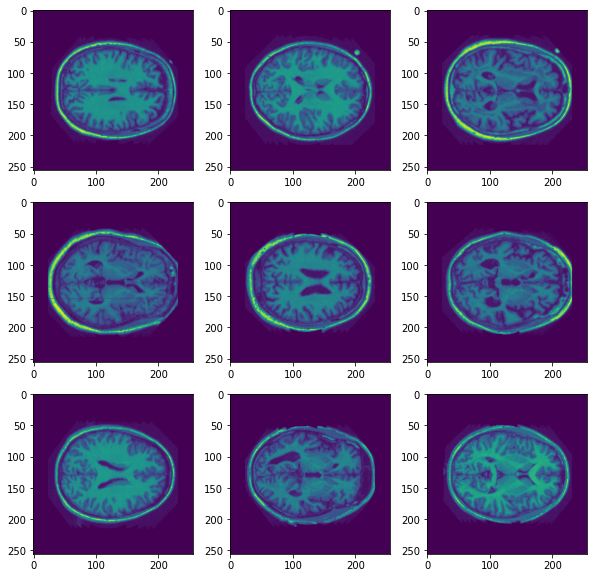

In [7]:
# Show the first scan of 9 patients in the training set
image_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i][:, :, 0])

plt.show()

In [8]:
class VectorQuantizer(layers.Layer):
    def __init__(self, num_embeddings, embedding_dim, label="vectorizer", beta=0.25, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.label = label
        self.beta = beta  # This parameter is best kept between [0.25, 2] as per the paper.

        # Initialize the embeddings which we will quantize.
        w_init = tf.random_uniform_initializer()
        self.embeddings = tf.Variable(
            initial_value=w_init(
                shape=(self.embedding_dim, self.num_embeddings), dtype="float32"
            ),
            trainable=True,
            name=self.label,
        )

    def call(self, x):
        input_shape = tf.shape(x)

        # Quantization.
        encoding_indices = self.get_code_indices(x)
        encodings = tf.one_hot(encoding_indices, self.num_embeddings)
        quantized = tf.matmul(encodings, self.embeddings, transpose_b=True)
        quantized = tf.reshape(quantized, input_shape)

        # Calculate vector quantization loss and add that to the layer. You can learn more
        # about adding losses to different layers here:
        # https://keras.io/guides/making_new_layers_and_models_via_subclassing/. Check
        # the original paper to get a handle on the formulation of the loss function.
        commitment_loss = self.beta * tf.reduce_mean(
            (tf.stop_gradient(quantized) - x) ** 2
        )
        codebook_loss = tf.reduce_mean((quantized - tf.stop_gradient(x)) ** 2)
        self.add_loss(commitment_loss + codebook_loss)

        # Straight-through estimator.
        quantized = x + tf.stop_gradient(quantized - x)
        return quantized

    def get_code_indices(self, x):
        # Calculate L2-normalized distance between the inputs and the codes.

        # flatten the inputs keeping `embedding_dim` intact.
        input_shape = tf.shape(x)
        flattened_inputs = tf.reshape(x, [-1, self.embedding_dim])
        print(f"Vector Quantizer {self.label} has input shape {input_shape} and flattened shape {flattened_inputs.shape}")
        print(f"Num Embeddings = {self.embedding_dim}, {self.embeddings.shape}")

        similarity = tf.matmul(flattened_inputs, self.embeddings)
        distances = (
            tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True)
            + tf.reduce_sum(self.embeddings ** 2, axis=0)
            - 2 * similarity
        )

        # Derive the indices for minimum distances.
        encoding_indices = tf.argmin(distances, axis=1)
        return encoding_indices


class SkipConn(layers.Layer):
    def __init__(self, in_channels, channels, **kwargs):
        super().__init__(**kwargs)

        self.conv1 = layers.Conv2D(channels, 3, activation="relu", padding="same")
        self.conv2 = layers.Conv2D(in_channels, 1, activation="relu", padding="same")

    def call(self, input):
        x = self.conv1(input)
        x = self.conv2(x)
        out = x + input
        return out


def get_encoder(input_shape, channels=128, strides=4, name='encoder'):
    encoder_inputs = Input(shape=input_shape, name=name+'input')

    if strides == 4:
        x = layers.Conv2D(channels // 2, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
        x = layers.Conv2D(channels, 3, activation="relu", strides=2, padding="same")(x)

    elif strides == 2:
        x = layers.Conv2D(channels // 2, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
        
    x = layers.Conv2D(channels, 3, activation="relu", padding="same")(x)

    for i in range(2):
        x = SkipConn(channels, 32)(x)
        
    return Model(inputs=encoder_inputs, outputs=x, name=name)


def get_decoder(input_shape, out_channels=128, channels=128, strides=4, name='decoder'):
    latent_inputs = Input(shape=input_shape, name=name+'decoder_input')

    x = layers.Conv2D(channels, 3, activation="relu", padding="same")(latent_inputs)

    for i in range(2):
        x = SkipConn(channels, 32)(x)

    if strides == 4:
        x = layers.Conv2DTranspose(channels // 2, 3, activation="relu", strides=2, padding="same")(x)

    decoder_outputs = layers.Conv2DTranspose(out_channels, 3, strides=2, padding="same")(x)
    return Model(inputs=latent_inputs, outputs=decoder_outputs, name=name)


In [9]:
class VQVAE(Model):
    def __init__(self, latent_dim=16, num_embeddings=128, embed_dim=192, n_embed=256):
        super(VQVAE, self).__init__()

        self.enc_b = get_encoder(input_shape=(256, 256, 1), channels=latent_dim, strides=4, name="encoder_b")
        self.enc_t = get_encoder(input_shape=(64, 64, latent_dim), channels=latent_dim, strides=2, name="encoder_t")
        #self.quantize_conv_t = layers.Conv2D(embed_dim, 1, activation="relu", padding="same")
        self.quantize_t = VectorQuantizer(num_embeddings, latent_dim, label="t_vq")

        self.dec_t = get_decoder(input_shape=(32, 32, latent_dim), out_channels=latent_dim, channels=latent_dim, strides=2, name="decoder_t")
        self.quantize_b = VectorQuantizer(n_embed, embed_dim, label="b_vq")
        self.upsample_t = layers.Conv2DTranspose(embed_dim, 3, activation="relu", strides=2, padding="same")

        self.dec = get_decoder(input_shape=(64, 64, 2 * latent_dim + embed_dim), out_channels=1, channels=latent_dim, strides=4, name="decoder_b")

    def encode(self, input):
        enc_b = self.enc_b(input)
        enc_t = self.enc_t(enc_b)

        quant_t = self.quantize_t(enc_t)

        dec_t = self.dec_t(quant_t)
        enc_b = tf.concat([dec_t, enc_b], 3)

        quant_b = self.quantize_b(enc_b)
        #upsample_t = self.upsample_t(quant_t)
        #quant = tf.concat([upsample_t, quant_b], 3)
        
        return quant_t, quant_b

    def decode(self, quant_t, quant_b):
        upsample_t = self.upsample_t(quant_t)
        quant = tf.concat([upsample_t, quant_b], 3)
        dec = self.dec(quant)

        return dec

    def encode_to_t(self, input):
        enc_b = self.enc_b(input)
        enc_t = self.enc_t(enc_b)
        return enc_t

    def encode_to_b(self, input):
        enc_b = self.enc_b(input)
        enc_t = self.enc_t(enc_b)

        quant_t = self.quantize_t(enc_t)

        dec_t = self.dec_t(quant_t)
        enc_b = tf.concat([dec_t, enc_b], 3)
        return enc_b

    def call(self, input):
        quant_t, quant_b = self.encode(input)
        dec = self.decode(quant_t, quant_b)

        return dec



In [13]:
class VQVAETrainer(tf.keras.models.Model):
    def __init__(self, train_variance, latent_dim=32, num_embeddings=128, embed_dim=192, model=None, **kwargs):
        super(VQVAETrainer, self).__init__(**kwargs)
        self.train_variance = train_variance
        self.latent_dim = latent_dim
        self.num_embeddings = num_embeddings

        if model is None:
            self.vqvae = VQVAE(self.latent_dim, self.num_embeddings, embed_dim=embed_dim)
        else:
            self.vqvae = model

        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.vq_loss_tracker = tf.keras.metrics.Mean(name="vq_loss")
        self.ssim = tf.keras.metrics.Mean(name="ssim")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.vq_loss_tracker,
            self.ssim,
        ]

    @tf.function
    def train_step(self, x):
        with tf.GradientTape() as tape:
            # Outputs from the VQ-VAE.
            reconstructions = self.vqvae(x)

            # Calculate the losses.
            reconstruction_loss = (
                tf.reduce_mean((x - reconstructions) ** 2) / self.train_variance
            )
            total_loss = reconstruction_loss + sum(self.vqvae.losses)

            ssim_score = tf.image.ssim(x + 0.5, reconstructions + 0.5, max_val=1.0)

        # Backpropagation.
        grads = tape.gradient(total_loss, self.vqvae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.vqvae.trainable_variables))

        # Loss tracking.
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.vq_loss_tracker.update_state(sum(self.vqvae.losses))
        self.ssim.update_state(ssim_score)

        # Log results.
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "vqvae_loss": self.vq_loss_tracker.result(),
            "ssim": self.ssim.result(),
        }

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [11]:
def generate_and_save_images(model, epoch, test_sample, save_dir):
    encoded_t, encoded_b = model.encode(test_sample)
    predictions = model.decode(encoded_t, encoded_b)
    fig = plt.figure(figsize=(4 * num_examples_to_generate, 8))

    for i in range(num_examples_to_generate):

        # display original + noise
        ax = plt.subplot(2, num_examples_to_generate, i + 1)
        plt.title("Original")
        plt.imshow(test_sample[i][:, :, 0])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        bx = plt.subplot(2, num_examples_to_generate, i + num_examples_to_generate + 1)
        plt.title("Reconstruction")
        plt.imshow(predictions[i][:, :, 0])
        bx.get_xaxis().set_visible(False)
        bx.get_yaxis().set_visible(False)

    # tight_layout minimizes the overlap between 2 sub-plots
    plt.savefig(save_dir / f'image_at_epoch_{epoch:04}.png')

    plt.show()

# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in val_ds.take(1):
    test_sample = test_batch[0:num_examples_to_generate, :, :, :]

# Create folders to store trained models and generated images in
model_path = Path('/root/trained_model')
if not os.path.exists(model_path):
    os.makedirs(model_path)
model_no = len(os.listdir(model_path)) + 1

model_path = model_path / f'model{model_no:03}'

save_path = Path('/root/image_sets')
if not os.path.exists(save_path):
    os.makedirs(save_path)
image_path = save_path / f'model{model_no:03}'
os.makedirs(image_path)

Epoch: 400/400
484/484 83s 171ms/step - loss: 637.7432861328125 - reconstruction_loss: 0.11680535227060318 - vqvae_loss: 637.6561279296875 - SSIM: 0.868410587310791


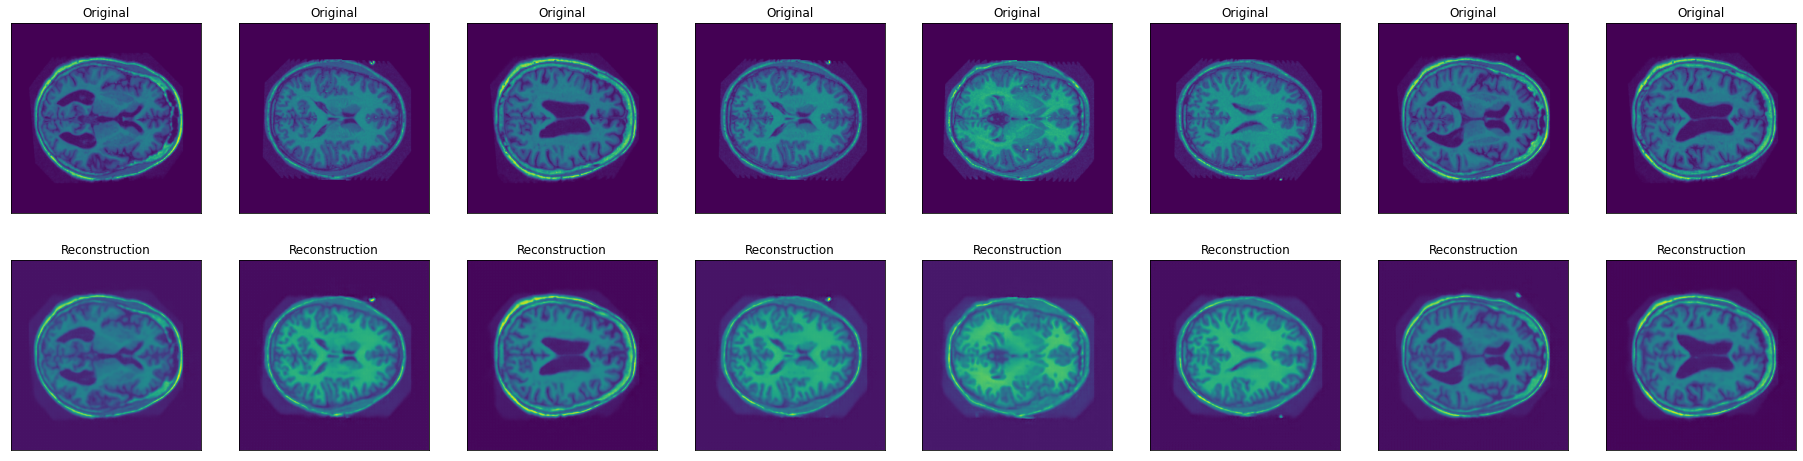

In [14]:
vqvae_trainer = VQVAETrainer(0.02, latent_dim=128, num_embeddings=256, embed_dim=128)
vqvae_trainer.compile(optimizer=tf.keras.optimizers.Adam(1e-4))
#vqvae_trainer.fit(train_ds, epochs=5, batch_size=batch_size)

generate_and_save_images(vqvae_trainer.vqvae, 0, test_sample, image_path)
loss_lists = []

for epoch in range(1, epochs + 1):
    start_time = time.time()
    step_time = 0
    iters = 0
    for train_x in tqdm(train_ds, desc=f"Epoch {epoch}/{epochs} - Model Step"):
        step_start = time.time()
        losses = vqvae_trainer.train_step(train_x)
        step_time = step_time + time.time() - step_start
        iters = iters + 1
    end_time = time.time()
    step_time = step_time / iters

    #loss = tf.keras.metrics.Mean()
    #for val_x in val_ds:
        #loss(compute_loss(vqvae_trainer, val_x))
    display.clear_output(wait=False)
    print(f"Epoch: {epoch}/{epochs}\n{iters}/{iters} {round(end_time - start_time)}s {round(step_time * 1000)}ms/step - loss: {losses['loss']} - reconstruction_loss: {losses['reconstruction_loss']} - vqvae_loss: {losses['vqvae_loss']} - SSIM: {losses['ssim']}")
    generate_and_save_images(vqvae_trainer.vqvae, epoch, test_sample, image_path)
    loss_lists.append([losses['loss'], losses['reconstruction_loss'], losses['vqvae_loss'], losses['ssim']])


INFO:tensorflow:Assets written to: \root\trained_model\model020\assets


INFO:tensorflow:Assets written to: \root\trained_model\model020\assets


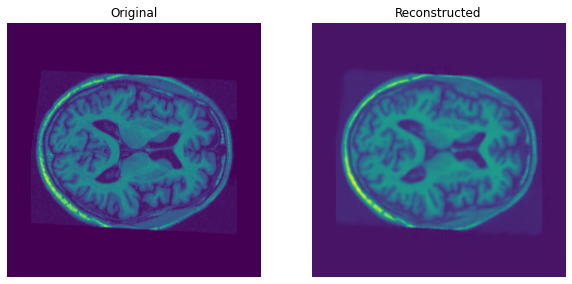

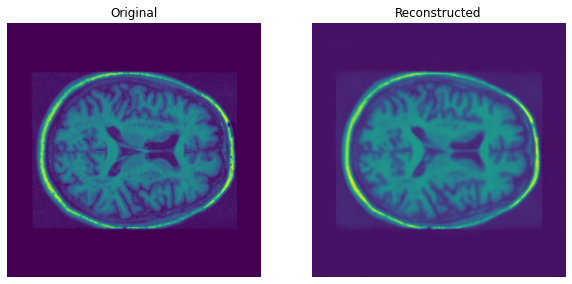

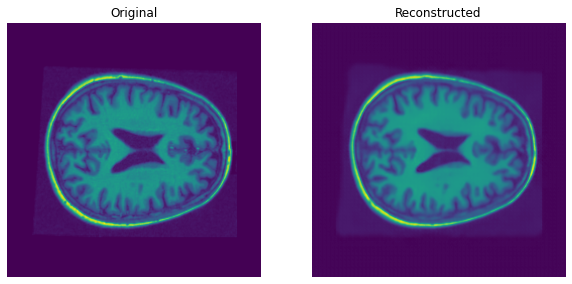

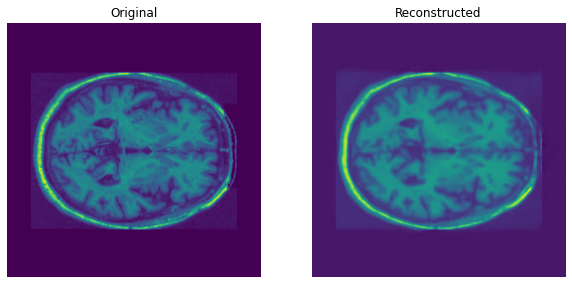

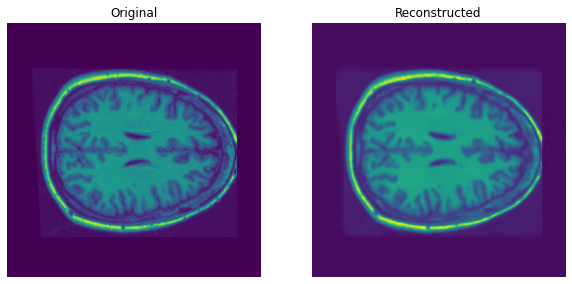

In [15]:
def show_subplot(original, reconstructed):

    original = original + 0.5
    reconstructed = reconstructed + 0.5

    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(original[:, :, 0])
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed[:, :, 0])
    plt.title("Reconstructed")
    plt.axis("off")

    plt.show()


trained_vqvae_model = vqvae_trainer.vqvae
trained_vqvae_model.save(model_path, save_traces=True)
test_images = next(iter(test_ds))
reconstructions_test = trained_vqvae_model.predict(test_images)

for i in range(5):
    show_subplot(test_images[i], reconstructions_test[i])


Low filter encoder is (20, 32, 32, 128), High filter encoder is (20, 64, 64, 256)


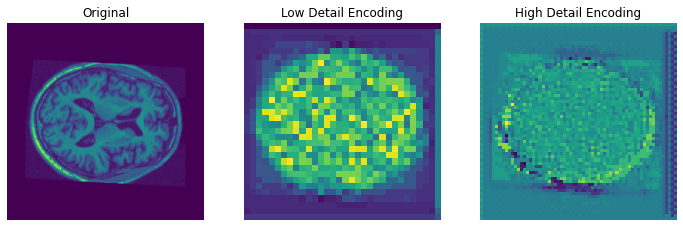

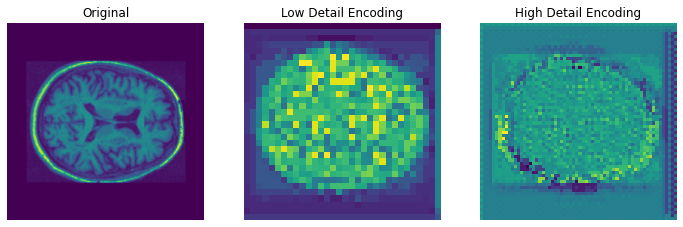

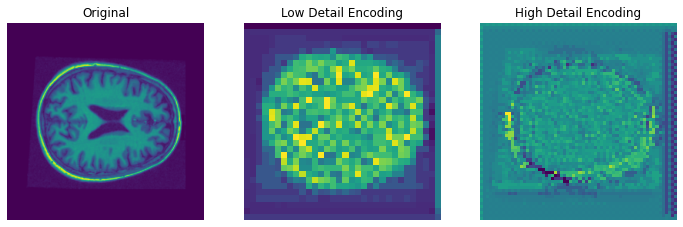

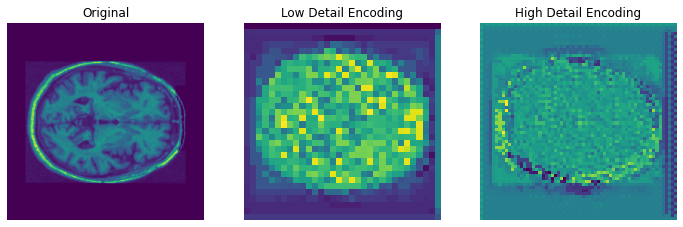

In [16]:
# Testing encoding visualisation
enc_out_t, enc_out_b = trained_vqvae_model.encode(test_images)
#enc_out = trained_vqvae_model.encode(test_images)
print(f"Low filter encoder is {enc_out_t.shape}, High filter encoder is {enc_out_b.shape}")
#print(f"Vector encoder is {enc_out.shape}.")

for i in range(4):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(test_images[i][:, :, 0] + 0.5)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(enc_out_t[i][:, :, 0] + 0.5) # 64 Filters
    plt.title("Low Detail Encoding")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(enc_out_b[i][:, :, 0] + 0.5) # 256 Filters
    plt.title("High Detail Encoding")
    plt.axis("off")
    plt.show()
# One hot encode the vector spaces to collapse them down.


In [ ]:
ssim_total = 0
count = 0

for batch in tqdm(test_ds):
    reconstructed_comp = trained_vqvae_model.predict(batch)

    for i in range(batch.shape[0]):
        original = tf.math.round((batch[i] + 0.5) * 255.0)
        reconstruction = tf.math.round((reconstructed_comp[i] + 0.5) * 255.0)
        ssim = tf.image.ssim(original, reconstruction, max_val=255.0)
        ssim_total += ssim
        count += 1

print(f"Average SSIM score is {ssim_total / count}.")

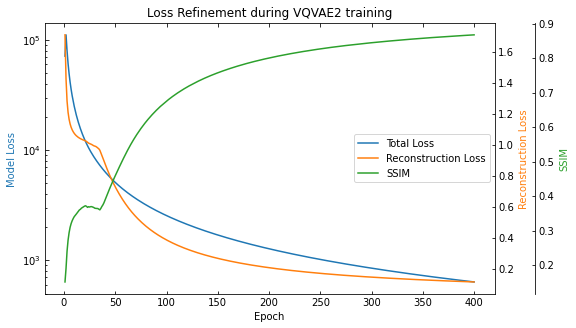

In [41]:
t_loss = []
r_loss = []
v_loss = []
ssims = []
xpoints = []

for group in loss_lists:
    t_loss.append(group[0])
    r_loss.append(group[1])
    v_loss.append(group[2])
    ssims.append(group[3])

for i in range(len(loss_lists)):
    xpoints.append(i + 1)

plt.figure(figsize=[10,5])

host = host_subplot(111, axes_class=AA.Axes)
plt.subplots_adjust(right=0.75)

par1 = host.twinx()
par2 = host.twinx()

offset = 40
new_fixed_axis = par2.get_grid_helper().new_fixed_axis
par2.axis["right"] = new_fixed_axis(loc="right", axes=par2,
                                        offset=(offset, 0))

p1, = host.plot(xpoints, t_loss, label='Total Loss')
#p2, = host.plot(xpoints, v_loss, label='VQVAE Loss')
p3, = par1.plot(xpoints, r_loss, label='Reconstruction Loss')

p4, = par2.plot(xpoints, ssims, label='SSIM')

host.set_xlabel("Epoch")
host.set_title("Loss Refinement during VQVAE2 training")
host.set_ylabel("Model Loss")
host.set_yscale('log')
par1.set_ylabel("Reconstruction Loss")
par2.set_ylabel("SSIM")

host.axis["left"].label.set_color(p1.get_color())
par1.axis["right"].label.set_color(p3.get_color())
par2.axis["right"].label.set_color(p4.get_color())

par1.axis["right"].toggle(all=True)
par2.axis["right"].toggle(all=True)

host.legend(loc='center right')

plt.draw()
plt.savefig('/root/testfile.png')
plt.show()

In [ ]:
# PixelCNN implementation
# The first layer is the PixelCNN layer. This layer simply
# builds on the 2D convolutional layer, but includes masking.
class PixelConvLayer(layers.Layer):
    def __init__(self, mask_type, **kwargs):
        super(PixelConvLayer, self).__init__()
        self.mask_type = mask_type
        self.conv = layers.Conv2D(**kwargs)

    def build(self, input_shape):
        # Build the conv2d layer to initialize kernel variables
        self.conv.build(input_shape)
        # Use the initialized kernel to create the mask
        kernel_shape = self.conv.kernel.get_shape()
        self.mask = np.zeros(shape=kernel_shape)
        self.mask[: kernel_shape[0] // 2, ...] = 1.0
        self.mask[kernel_shape[0] // 2, : kernel_shape[1] // 2, ...] = 1.0
        if self.mask_type == "B":
            self.mask[kernel_shape[0] // 2, kernel_shape[1] // 2, ...] = 1.0
        self.mask = tf.cast(self.mask, tf.float32)

    def call(self, inputs):
        self.conv.kernel.assign(self.conv.kernel * self.mask)
        return tf.cast(self.conv(inputs), tf.float32)


# Next, we build our residual block layer.
# This is just a normal residual block, but based on the PixelConvLayer.
class ResidualBlock(layers.Layer):
    def __init__(self, filters, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.conv1 = layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )
        self.pixel_conv = PixelConvLayer(
            mask_type="B",
            filters=filters // 2,
            kernel_size=3,
            activation="relu",
            padding="same",
        )
        self.conv2 = layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pixel_conv(x)
        x = self.conv2(x)
        return layers.add([inputs, x])


def pixel_cnn(shape, filters=128, kernels=64, embeddings=128, name="pixel_cnn"):
    pixelcnn_inputs = Input(shape=shape, dtype=tf.int32)
    ohe = tf.one_hot(pixelcnn_inputs, embeddings)
    ohe = tf.cast(ohe, tf.float32)
    x = PixelConvLayer(
        mask_type="A", filters=filters, kernel_size=kernels, activation="relu", padding="same"
    )(ohe)

    for _ in range(2):
        x = ResidualBlock(filters=filters)(x)

    for _ in range(2):
        x = PixelConvLayer(
            mask_type="B",
            filters=filters,
            kernel_size=1,
            strides=1,
            activation="relu",
            padding="valid",
        )(x)

    out = layers.Conv2D(
        filters=embeddings, kernel_size=1, strides=1, padding="valid"
    )(x)

    return Model(pixelcnn_inputs, out, name=name)


In [ ]:
# Generate an encoded dataset

def codebooks_t(ds):
    encoded_outputs = trained_vqvae_model.encode_to_t(ds)
    flat_enc_outputs = tf.reshape(encoded_outputs, [-1, encoded_outputs.shape[-1]])
    codebook_indices = trained_vqvae_model.quantize_t.get_code_indices(flat_enc_outputs)
    codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])

    return codebook_indices

def codebooks_b(ds):
    encoded_outputs = trained_vqvae_model.encode_to_b(ds)
    flat_enc_outputs = tf.reshape(encoded_outputs, [-1, encoded_outputs.shape[-1]])
    codebook_indices = trained_vqvae_model.quantize_b.get_code_indices(flat_enc_outputs)
    codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])

    return codebook_indices

pixel_ds = configure_for_performance(train_ds_raw, 10)

codebook_tensor_t = 0
codebook_tensor_b = 0
first = True

for batch in pixel_ds:
    if first:
        codebook_tensor_t = codebooks_t(batch)
        #codebook_tensor_b = codebooks_b(batch)
        first = False
    else:
        codebook_tensor_t = tf.concat([codebook_tensor_t, codebooks_t(batch)], 0)
        #codebook_tensor_b = tf.concat([codebook_tensor_b, codebooks_b(batch)], 0)


In [ ]:
pixel_cnn_t = pixel_cnn((32, 32), filters=128, kernels=64, embeddings=128, name="pixel_cnn_top")
#pixel_cnn_b = pixel_cnn((64, 64), filters=128, kernels=64, embeddings=128, name="pixel_cnn_bottom")

pixel_cnn_t.compile(
    optimizer=tf.keras.optimizers.Adam(3e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

#pixel_cnn_b.compile(
    #optimizer=tf.keras.optimizers.Adam(3e-4),
    #loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    #metrics=["accuracy"],
#)

pixel_cnn_t.fit(
    x=codebook_tensor_t,
    y=codebook_tensor_t,
    batch_size=20,
    epochs=3,
    validation_split=0.1,
)

#pixel_cnn_b.fit(
    #x=codebook_tensor_b,
    #y=codebook_tensor_b,
    #batch_size=20,
    #epochs=3,
    #validation_split=0.1,
#)

In [ ]:
trained_vqvae_model.summary()